# Refine labels for Dendritic cells

In this notebook, we load all cDCs, and pDCs across our subjects to refine final L3 labels. We'll combine, recluster, and assign final labels by taking the most frequent AIFI_L3 label in each cluster, and back-propogate those L3 labels to L2 and L1 based on our cell type hierarcy.

We'll also generate metadata, UMAP coordinates, and marker gene summaries for review of our final labels, then store all of the outputs in HISE for later use.

## Load packages

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

import concurrent.futures
from concurrent.futures import ThreadPoolExecutor
from datetime import date
import hisepy
import os
import pandas as pd
import scanpy as sc
import scanpy.external as sce

In [2]:
out_dir = 'output'
if not os.path.isdir(out_dir):
    os.makedirs(out_dir)

In [3]:
class_name = 'dc'

## Helper functions

These functions make it easy to utilize files from the HISE cache

In [4]:
def cache_uuid_path(uuid):
    cache_path = '/home/jupyter/cache/{u}'.format(u = uuid)
    if not os.path.isdir(cache_path):
        hise_res = hisepy.reader.cache_files([uuid])
    filename = os.listdir(cache_path)[0]
    cache_file = '{p}/{f}'.format(p = cache_path, f = filename)
    return cache_file

In [5]:
def read_csv_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = pd.read_csv(cache_file)
    return res

In [6]:
def read_adata_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = sc.read_h5ad(cache_file)
    return res

This function uses the most frequent label within each cluster to refine label assignments.

In [7]:
def single_value(series):
    res = []
    for value in series:
        if isinstance(value, pd.core.arrays.categorical.Categorical) or isinstance(value, list):
            res.append(value[0])
        else:
            res.append(value)
    return res

In [8]:
def assign_most_frequent(adata, clusters, labels, keep_original = False, original_prefix = 'predicted_'):
    obs = adata.obs
    
    most_frequent_labels = (
        adata.obs
        .groupby(clusters)[labels]
        .agg(pd.Series.mode)
        .to_frame()
        .reset_index()
    )
    most_frequent_labels[labels] = single_value(most_frequent_labels[labels])
    
    if keep_original:
        obs = obs.rename({labels: original_prefix + labels}, axis = 1)
    else:
        obs = obs.drop(labels, axis = 1)
    
    obs = obs.merge(most_frequent_labels, on = clusters, how = 'left')
    
    adata.obs = obs
    
    return adata

This function can be used to update labels resulting from iterative subclustering.

In [9]:
def label_substitution(adata, labels):
    sub_idx = adata.obs['barcodes'].isin(labels['barcodes'])
    sub_adata = adata[sub_idx]
    
    adata = adata[[not x for x in sub_idx]]
    
    sub_obs = sub_adata.obs.drop(['AIFI_L3', 'predicted_AIFI_L3'], axis = 1)
    sub_obs = sub_obs.reset_index(drop = True)
    sub_obs = sub_obs.merge(labels, on = 'barcodes', how = 'left')
    sub_obs = sub_obs.set_index('barcodes', drop = False)
    sub_adata.obs = sub_obs
    
    adata = sc.concat([adata, sub_adata])
    return adata

This function back-propagates hierarchical labeling from AIFI_L3 back to AIFI_L2 and AIFI_L1 to ensure our labels agree across levels of our cell type hierarchy.

In [10]:
def propagate_hierarchy(
    adata,
    hierarchy_df,
    from_level = 'AIFI_L3',
    to_levels = ['AIFI_L2', 'AIFI_L1'],
    keep_original = True,
    original_prefix = 'predicted_'
):
    obs = adata.obs
    
    for to_level in to_levels:
        prop_df = hierarchy_df[[from_level, to_level]]
        prop_df = prop_df.drop_duplicates()
        
        if keep_original:
            obs = obs.rename({to_level: original_prefix + to_level}, axis = 1)
        else:
            obs = obs.drop(to_level, axis = 1)

        obs = obs.merge(prop_df, on = from_level, how = 'left')

    adata.obs = obs

    return adata

These functions are used to assemble marker gene expression tables for review

In [11]:
def marker_frac_df(adata, markers, clusters = 'louvain_2'):
    gene_cl_frac = sc.pl.dotplot(
        adata, 
        groupby = clusters,
        var_names = markers,
        return_fig = True
    ).dot_size_df
    return gene_cl_frac

def marker_mean_df(adata, markers, log = False, clusters = 'louvain_2'):
    gene_cl_mean = sc.pl.dotplot(
        adata, 
        groupby = clusters,
        var_names = markers,
        return_fig = True,
        log = log
    ).dot_color_df
    
    return gene_cl_mean

def tidy_marker_df(adata, markers, clusters = 'louvain_2'):
    gene_cl_frac = marker_frac_df(adata, markers, clusters)
    gene_cl_frac = gene_cl_frac.reset_index(drop = False)
    gene_cl_frac = pd.melt(gene_cl_frac, id_vars = clusters, var_name = 'gene', value_name = 'gene_frac')
    
    gene_cl_mean = marker_mean_df(adata, markers, log = False, clusters = clusters)
    gene_cl_mean = gene_cl_mean.reset_index(drop = False)
    gene_cl_mean = pd.melt(gene_cl_mean, id_vars = clusters, var_name = 'gene', value_name = 'gene_mean')

    marker_df = gene_cl_frac.merge(gene_cl_mean, on = [clusters, 'gene'], how = 'left')
    return marker_df

This function will select clusters based on gene detection above a specifiec fraction of cells (cutoff).

In [12]:
def select_clusters_above_gene_frac(adata, gene, cutoff, clusters = 'louvain_2'):
    gene_cl_frac = marker_frac_df(adata, gene, clusters)
    select_cl = gene_cl_frac.index[gene_cl_frac[gene] > cutoff].tolist()

    return select_cl

This function applies data analysis methods to our scRNA-seq data, including normalization, HVG selection, PCA, nearest neighbors, UMAP, and Leiden clustering.

In [13]:
def process_adata(adata, resolution = 2):
    
    # Keep a copy of the raw data
    adata = adata.raw.to_adata()
    adata.raw = adata

    print('Normalizing', end = "; ")
    # Normalize and log transform
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)

    print('Finding HVGs', end = "; ")
    # Restrict downstream steps to variable genes
    sc.pp.highly_variable_genes(adata)
    adata = adata[:, adata.var_names[adata.var['highly_variable']]].copy()

    print('Scaling', end = "; ")
    # Scale variable genes
    sc.pp.scale(adata)

    print('PCA', end = "; ")
    # Run PCA
    sc.tl.pca(adata, svd_solver = 'arpack')

    # print('Harmony', end = "; ")
    # # Integrate subjects
    # sce.pp.harmony_integrate(
    #     adata, 
    #     'subject.subjectGuid',
    #     max_iter_harmony = 30,
    #     verbose = False
    # )
    
    print('Neighbors', end = "; ")
    # Find nearest neighbors
    sc.pp.neighbors(
        adata, 
        n_neighbors = 30,
        n_pcs = 30,
        # use_rep = 'X_pca_harmony'
    )

    print('Leiden', end = "; ")
    # Find clusters
    sc.tl.leiden(
        adata, 
        resolution = resolution, 
        key_added = 'leiden_{r}'.format(r = resolution),
        n_iterations = 2
    )

    print('UMAP', end = "; ")
    # Run UMAP
    sc.tl.umap(adata, min_dist = 0.05)
    
    print('Renormalizing')
    adata = adata.raw.to_adata()
    adata.raw = adata

    # Normalize and log transform
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    
    return adata

This function retrieves both observations and UMAP coordinates in a single table for review.

In [14]:
def obs_with_umap(adata):
    obs = adata.obs
    
    umap_mat = adata.obsm['X_umap']
    umap_df = pd.DataFrame(umap_mat, columns = ['umap_1', 'umap_2'])
    obs['umap_1'] = umap_df['umap_1']
    obs['umap_2'] = umap_df['umap_2']

    return obs

This function is used to iteratively refine cDC2 cluster boundaries

In [15]:
def vcan_refinement(adata, clusters = 'leiden_3', refine_res = 1):
    vcan_hi_cl = select_clusters_above_gene_frac(
        adata, 'VCAN', 0.6, clusters = clusters
    )
    print(vcan_hi_cl)
    
    vcan_adata = adata[adata.obs[clusters].isin(vcan_hi_cl)]
    
    vcan_adata = process_adata(vcan_adata, resolution = refine_res)
    vcan_adata = assign_most_frequent(
        vcan_adata, 
        'leiden_{r}'.format(r = refine_res), 'AIFI_L3',
        keep_original = True,
        original_prefix = 'predicted_'
    )

    vcan_df = vcan_adata.obs[['barcodes', 'AIFI_L3', 'predicted_AIFI_L3']]
    return vcan_df

## Read cell type hierarchy from HISE

As part of label refinement, we'll back-propagate our cell type labels from refined AIFI_L3 labels to their parent cell classes at AIFI_L2 and AIFI_L1. To do this, we need the hierarchical relationships between these levels, which have been generated for our cell type reference dataset.

In [16]:
hierarchy_uuid = '1a44252c-8cab-4c8f-92c9-d8f3af633790'
hierarchy_df = read_csv_uuid(hierarchy_uuid)

## Identify files in HISE

For this analysis, we'll read in these files from HISE storage from previous steps. We'll group these into "large" files, which are from the set of 5 very large cell type assignments, and "small" files, which are from other cell types.

In [17]:
h5ad_uuids = {
    'cDC1': '8728233c-e99c-4c93-921e-18f56ba72b75',
    'cDC2': '74207276-23b2-4943-8c02-02ca4d12473b',
    'pDC': 'ae861863-fd93-42aa-91d0-7a66c3528831'
}

## Read and assemble datasets

In [18]:
adata_dict = {}
for group_name, uuid in h5ad_uuids.items():
    adata_dict[group_name] = read_adata_uuid(uuid)

In [19]:
adata = sc.concat(adata_dict)

## Process data

Here, we'll process all of our cells together for clustering and review.

In [20]:
out_h5ad = out_file = 'output/diha_{c}_AIFI_L3_review_{d}.h5ad'.format(
    c = class_name,
    d = date.today()
)

In [21]:
adata = process_adata(adata)

Normalizing; Finding HVGs; Scaling; PCA; Neighbors; Leiden; UMAP; Renormalizing


## Refine cell labels

### Subset cDC2 clusters

In [23]:
cdc2_labels = vcan_refinement(adata, clusters = 'leiden_2')

['5', '8', '10', '11', '12', '14', '15', '16', '19']
Normalizing; WARNING: adata.X seems to be already log-transformed.
Finding HVGs; Scaling; PCA; Neighbors; Leiden; UMAP; Renormalizing


In [25]:
adata = assign_most_frequent(
    adata, 
    'leiden_2', 'AIFI_L3', 
    keep_original = True,
    original_prefix = 'predicted_'
)

In [ ]:
adata = label_substitution(adata, cdc2_labels)

/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [ ]:
adata = propagate_hierarchy(
    adata,
    hierarchy_df,
    from_level = 'AIFI_L3',
    to_levels = ['AIFI_L2', 'AIFI_L1'],
    keep_original = True,
    original_prefix = 'predicted_'
)

## Plot refinement

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


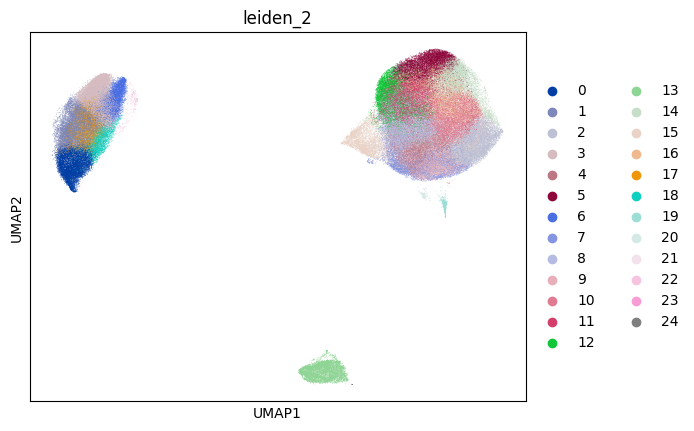

In [30]:
sc.pl.umap(adata, color = 'leiden_2')

**CellTypist Labels**

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


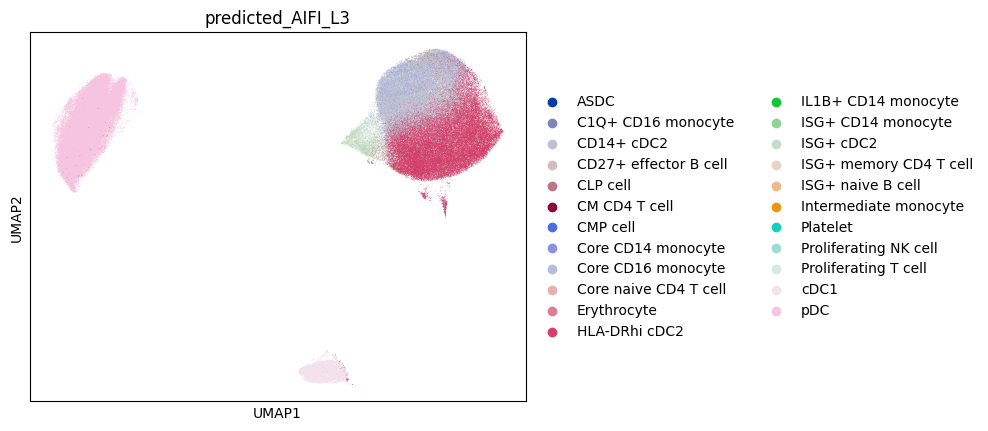

In [31]:
sc.pl.umap(adata, color = 'predicted_AIFI_L3')

**Refined Labels**

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


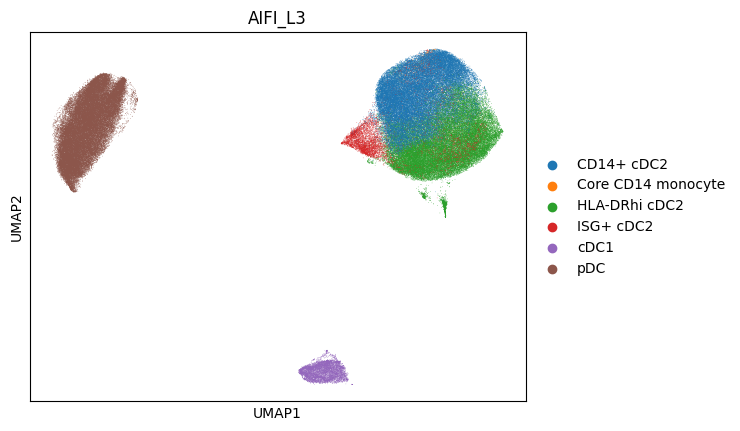

In [32]:
sc.pl.umap(adata, color = 'AIFI_L3')

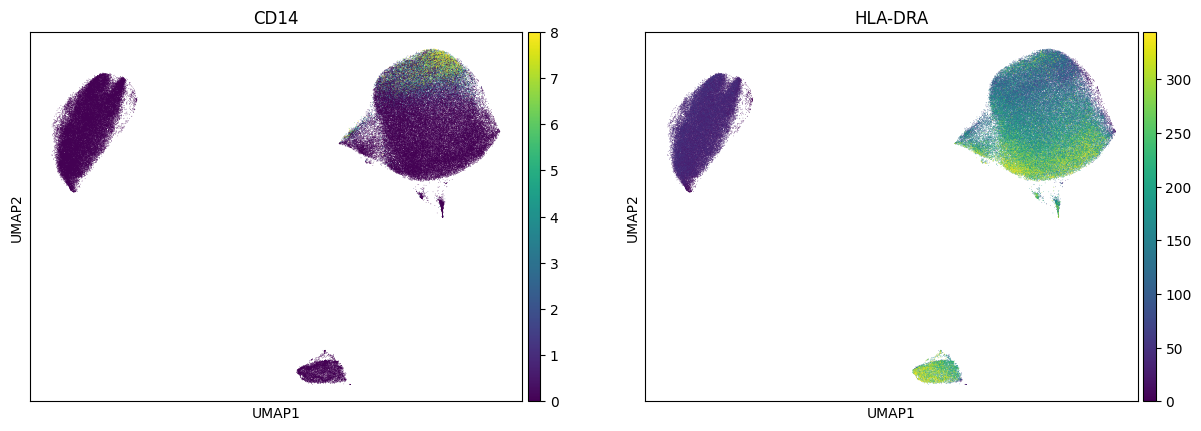

In [33]:
sc.pl.umap(adata, color = ['CD14','HLA-DRA'], vmax = 'p99')

## Write Outputs to disk

### AnnData object

In [24]:
adata.write_h5ad(out_h5ad)

### Cell metadata and UMAP Coordinates

In [25]:
out_meta = 'output/diha_{c}_AIFI_L3_review_meta_{d}.csv'.format(
    c = class_name,
    d = date.today()
)

In [26]:
obs = obs_with_umap(adata)
obs.to_csv(out_meta)

### Marker gene expression summaries

In [25]:
l2_markers = [
    'AXL', 'C1orf54', 'CD14', 'CD1C', 'CD74',
    'CDKN1C', 'CLEC9A', 'CST3', 'FCGR3A', 'HLA-DRA',
    'IL3RA', 'IRF8', 'ITM2C', 'PLAC8', 'S100A10',
    'S100A9', 'SIGLEC6', 'SPI1', 'VCAN'
]

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


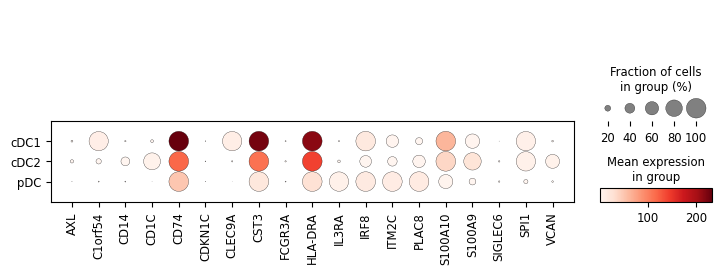

In [27]:
sc.pl.dotplot(adata, groupby = 'AIFI_L2', var_names = l2_markers)

In [28]:
out_l2_markers = 'output/diha_{c}_AIFI_L2_review_markers_{d}.csv'.format(
    c = class_name,
    d = date.today()
)
l2_marker_df = tidy_marker_df(
    adata,
    l2_markers,
    'AIFI_L2'
)
l2_marker_df.to_csv(out_l2_markers)

In [29]:
l3_markers = [
    'AXL', 'C1QA', 'C1QB', 'C1orf54', 'CCL3',
    'CD14', 'CD163', 'CD1C', 'CD68', 'CD74',
    'CLEC9A', 'CST3', 'FCGR3A', 'GAPDH', 'HLA-DPA1',
    'HLA-DRA', 'IFI44L', 'IL1B', 'IL3RA', 'IRF8',
    'ISG15', 'ITM2C', 'MX1', 'NFKBIA', 'PLAC8',
    'S100A10', 'S100A8', 'S100A9', 'SIGLEC6', 'SMIM25',
    'SOD2', 'SPI1', 'VCAN'
]

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


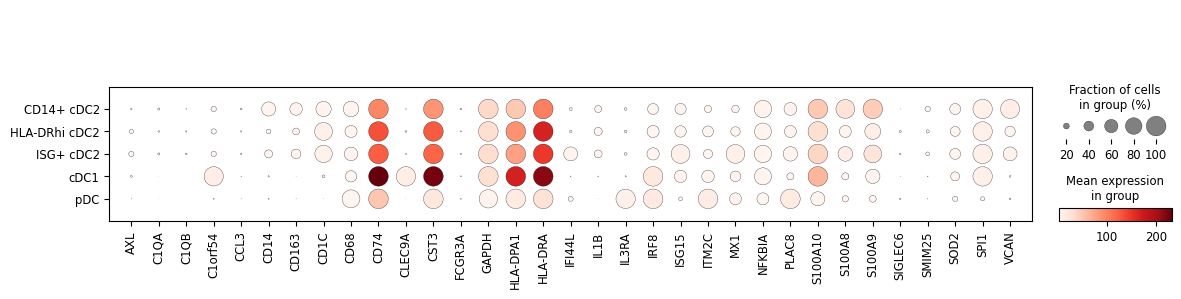

In [30]:
sc.pl.dotplot(adata, groupby = 'AIFI_L3', var_names = l3_markers)

In [30]:
out_l3_markers = 'output/diha_{c}_AIFI_L3_review_markers_{d}.csv'.format(
    c = class_name,
    d = date.today()
)
l3_marker_df = tidy_marker_df(
    adata,
    l3_markers,
    'AIFI_L3'
)
l3_marker_df.to_csv(out_l3_markers)

## Upload Cell Type data to HISE

Finally, we'll use `hisepy.upload.upload_files()` to send a copy of our output to HISE to use for downstream analysis steps.

In [31]:
study_space_uuid = 'de025812-5e73-4b3c-9c3b-6d0eac412f2a'
title = 'DIHA DC L3 Label Refinement {d}'.format(d = date.today())

In [32]:
in_files = list(h5ad_uuids.values())
in_files

['8728233c-e99c-4c93-921e-18f56ba72b75',
 '74207276-23b2-4943-8c02-02ca4d12473b',
 'ae861863-fd93-42aa-91d0-7a66c3528831']

In [33]:
out_files = [out_h5ad, out_meta, out_l2_markers, out_l3_markers]

In [34]:
out_files

['output/diha_dc_AIFI_L3_review_2024-03-22.h5ad',
 'output/diha_dc_AIFI_L3_review_meta_2024-03-23.csv',
 'output/diha_dc_AIFI_L2_review_markers_2024-03-23.csv',
 'output/diha_dc_AIFI_L3_review_markers_2024-03-23.csv']

In [35]:
hisepy.upload.upload_files(
    files = out_files,
    study_space_id = study_space_uuid,
    title = title,
    input_file_ids = in_files
)

output/diha_dc_AIFI_L3_review_2024-03-22.h5ad
output/diha_dc_AIFI_L3_review_meta_2024-03-23.csv
output/diha_dc_AIFI_L2_review_markers_2024-03-23.csv
output/diha_dc_AIFI_L3_review_markers_2024-03-23.csv
you are trying to upload file_ids... ['output/diha_dc_AIFI_L3_review_2024-03-22.h5ad', 'output/diha_dc_AIFI_L3_review_meta_2024-03-23.csv', 'output/diha_dc_AIFI_L2_review_markers_2024-03-23.csv', 'output/diha_dc_AIFI_L3_review_markers_2024-03-23.csv']. Do you truly want to proceed?


(y/n) y


{'trace_id': '3df95d0c-be21-4aef-942d-153436de3fb2',
 'files': ['output/diha_dc_AIFI_L3_review_2024-03-22.h5ad',
  'output/diha_dc_AIFI_L3_review_meta_2024-03-23.csv',
  'output/diha_dc_AIFI_L2_review_markers_2024-03-23.csv',
  'output/diha_dc_AIFI_L3_review_markers_2024-03-23.csv']}

In [36]:
import session_info
session_info.show()